In [277]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
%matplotlib inline
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

## Get data

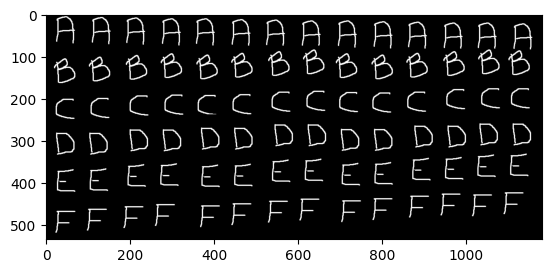

In [278]:
# Get the data
img = cv.imread('Data/alpha.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = cv.resize(gray, (280, 120))
# read the image
im = plt.imread('Data/alpha.png')
# Show the image
plt.imshow(im)
plt.show()

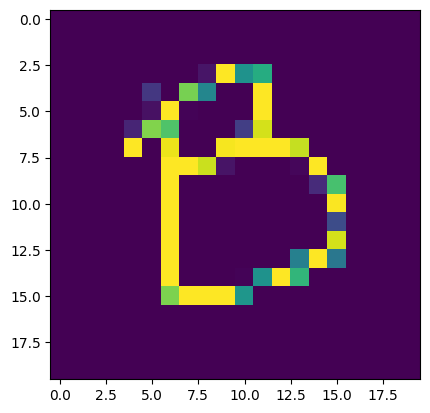

In [279]:
# Split cells and show the letter B
cells = [np.hsplit(row,14) for row in np.vsplit(gray,6)]
x = np.array(cells)
plt.imshow(x[1][1])
plt.show()

## Shape into features and labels

In [280]:
features = x[:,:14].reshape(-1,400)
features.shape

(84, 400)

In [281]:
k = np.arange(6)
labels = np.repeat(k,14)
labels.shape

(84,)

In [282]:
# CPU or CUDA
cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(cuda)

cpu


In [283]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=1)

# Normalize to range 0-1
X_train = X_train/255.0
X_test = X_test/255.0

In [284]:
# Covert to torch tensors and print shape
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
print("Features train: ", X_train_tensor.shape)

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
print("Features test: ", X_test_tensor.shape)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
print("Labels train: ", y_train_tensor.shape)

y_test_tensor = torch.tensor(y_test, dtype=torch.long)
print("Labels test: ", y_test_tensor.shape)

Features train:  torch.Size([50, 400])
Features test:  torch.Size([34, 400])
Labels train:  torch.Size([50])
Labels test:  torch.Size([34])


In [285]:
# Reshape images
X_train_tensor = torch.Tensor(X_train_tensor.reshape((-1, 1, 20, 20)))
X_test_tensor = torch.Tensor(X_test_tensor.reshape((-1, 1, 20, 20)))
print("X_train: ", X_train_tensor.shape)
print("X_test: ", X_test_tensor.shape)
print("y train: ", y_train_tensor.shape)
print("y test: ", y_test_tensor.shape)

X_train:  torch.Size([50, 1, 20, 20])
X_test:  torch.Size([34, 1, 20, 20])
y train:  torch.Size([50])
y test:  torch.Size([34])


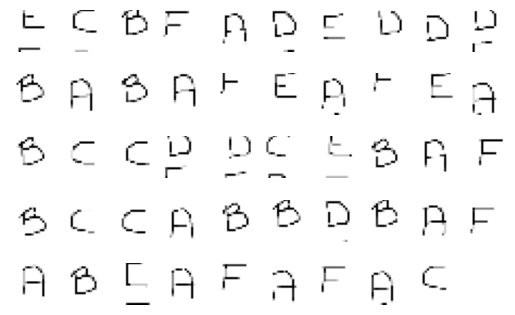

In [361]:
# Randomize dataset and show image
figure = plt.figure()
num_of_images = 49
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(X_train_tensor[index].numpy().squeeze(), cmap='gray_r')

In [407]:
def train_model(model, epochs, x, y):
    x = X_train_tensor.to(cuda)
    y = y_train_tensor.to(cuda)
    x = X_train_tensor.view(X_train_tensor.shape[0], -1)
    
    # Parameters
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_list = list()

    for epoch in range(1, epochs):

        # Calculate output and loss
        outputs = model(x)
        loss = criterion(outputs, y)

        # Zero out gradient
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        #print(f'Epoch: {epoch} Loss {loss.item()}')
        loss_list.append(loss.item())
        
    return loss_list

In [408]:
# X_test_tensor, y_test_tensor
def evaluate_model(model, x, y):
    x = X_test_tensor.to(cuda)
    y = y_test_tensor.to(cuda)
    model.eval()
    x = x.view(x.shape[0], -1)
    


    with torch.no_grad():
        correct = 0
        total = 0
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)

        y_test = y.cpu().numpy()
        predicted = predicted.cpu()

        accuracy_cnn = accuracy_score(predicted, y_test)

    acc = int(accuracy_cnn*100)
    
    return acc


In [409]:
def plot_loss(epochs, loss_list):
    x = (range(1, epochs))
    plt.figure(figsize=(12,8))
    plt.plot(x, loss_list, linewidth=2, markersize=12, color='purple')
    plt.xlabel('Epoch', fontsize=22, color='white')
    plt.ylabel('Loss', fontsize=22, color='white')
    plt.gcf().set_facecolor("purple");

In [410]:
# X_test_tensor
def test_model(x, m):
    list_of_labels = ['A', 'B', 'C', 'D', 'E', 'F']
    
    img = x[0].view(1, 400)
    with torch.no_grad():
        logps = m(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    predicted_letter = probab.index(max(probab))
    print("Predicted letter =", list_of_labels[predicted_letter])

    reshape_img = img.reshape((-1, 1, 20, 20))
    plt.imshow(reshape_img[0][0])
    plt.show()
    

## Set sizes

In [411]:
# 20x20 pixels
input_size = 400
# Hidden layers size
#hidden_sizes = [64, 32, 16]
#hidden_sizes = [128, 64, 32]
#hidden_sizes = [512, 256, 128]
#hidden_sizes = [1024, 512, 256]
hidden_sizes = [2048, 1024, 512]
#hidden_sizes = [4096, 2048, 1024]
# The 6 labels
output_size = 6

In [412]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = hidden_sizes[0]
        hidden_2 = hidden_sizes[1]
        hidden_3 = hidden_sizes[2]
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, output_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        # Flatten image
        out = x.view(-1, input_size)
        # Hidden layer, relu activation
        out = F.relu(self.fc1(out))
        # Dropout
        out = self.dropout(out)
        # Hidden layer, relu activation
        out = F.relu(self.fc2(out))
        # Dropout
        out = self.dropout(out)
        # Hidden layer, relu activation
        out = F.relu(self.fc3(out))
        # Dropout
        out = self.dropout(out)
        # Output
        out = self.fc4(out)
        return out

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=400, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [413]:
# Train model 1
epochs = 100
loss_list = train_model(model, epochs, X_train_tensor, y_train_tensor)

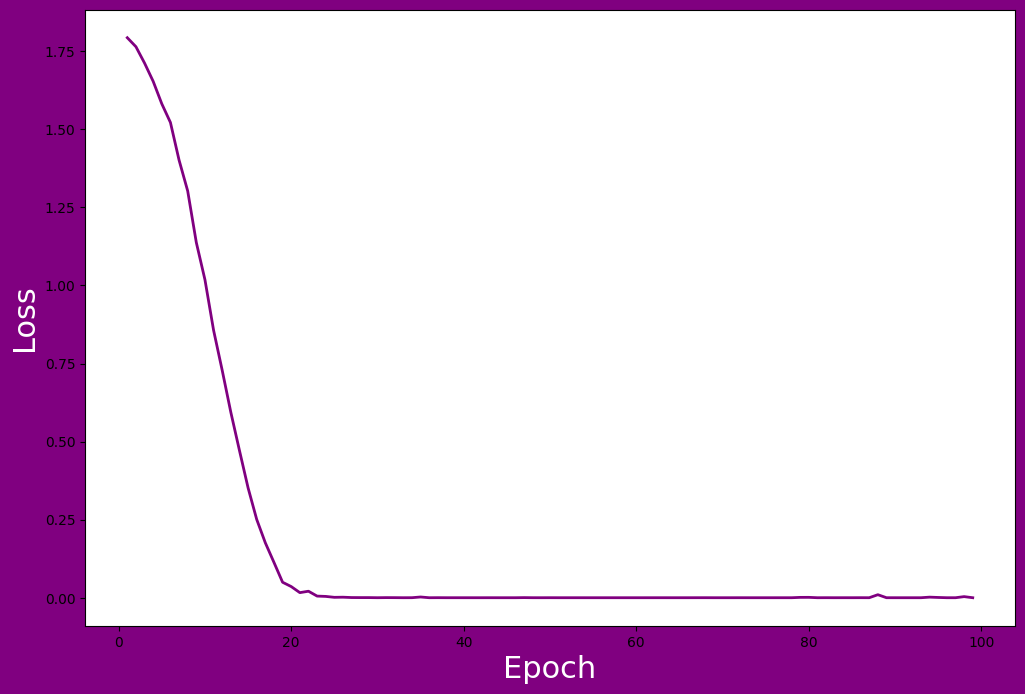

In [414]:
plot_loss(100, loss_list)

In [415]:
acc_1 = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f'Accuracy of model: {acc_1}%')

Accuracy of model: 38%


Predicted letter = A


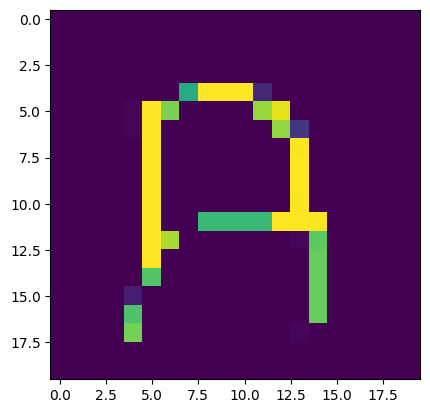

In [416]:
test_model(X_test_tensor, model)

## Model test 2

In [417]:
# Set sizes
# 20x20 pixels
input_size2 = 400
# Hidden layers size
#hidden_sizes = [32, 16]
#hidden_sizes2 = [256, 128]
#hidden_sizes2 = [512, 256]
#hidden_sizes2 = [1024, 512]
hidden_sizes2 = [2048, 1024]
# The 6 labels
output_size2 = 6

In [418]:
# Model
class CNN(nn.Module):

    output_size = 6
    def __init__(self):
        super(CNN, self).__init__()
        hidden_1 = hidden_sizes2[0]
        hidden_2 = hidden_sizes2[1]
        self.fc1 = nn.Linear(input_size2, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, output_size2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Flatten image
        out = x.view(-1, input_size2)
        # Hidden layer, relu activation
        out = F.relu(self.fc1(out))
        # Dropout
        out = self.dropout(out)
        
        # Hidden layer, relu activation
        out = F.relu(self.fc2(out))
        # Dropout
        out = self.dropout(out)

        # Output
        out = self.fc3(out)
        return out

model_2 = CNN()
print(model_2)

CNN(
  (fc1): Linear(in_features=400, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [419]:
# Train model 1
epochs = 100
loss_list2 = train_model(model_2, epochs, X_train_tensor, y_train_tensor)

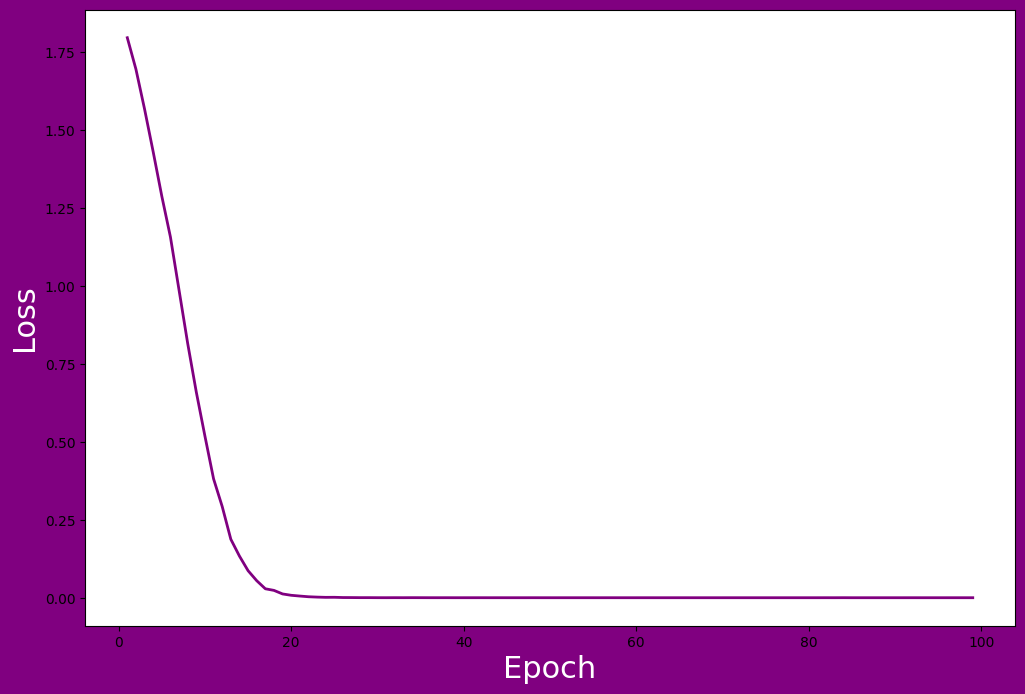

In [420]:
plot_loss(100, loss_list2)

In [421]:
acc_2 = evaluate_model(model_2, X_test_tensor, y_test_tensor)
print(f'Accuracy of model 2: {acc_2}%')

Accuracy of model 2: 50%


## Compare models

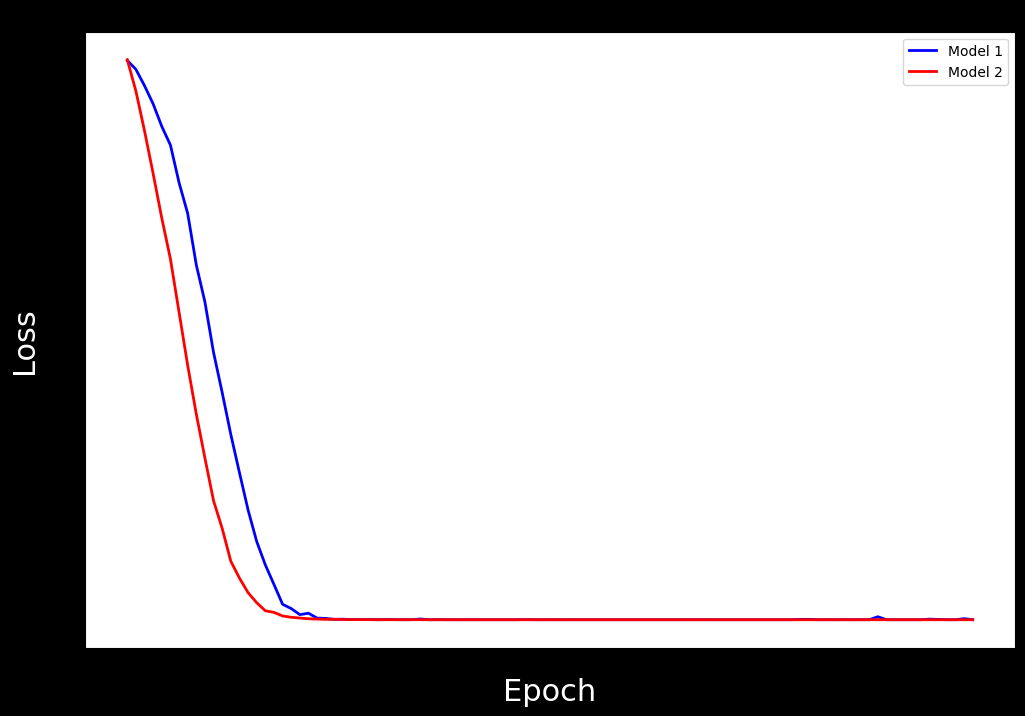

In [422]:
x = (range(1, 100))
plt.figure(figsize=(12,8))
plt.plot(x, loss_list, linewidth=2, markersize=12, color='blue', label='Model 1')
plt.plot(x, loss_list2, linewidth=2, markersize=12, color='red', label='Model 2')
plt.xlabel('Epoch', fontsize=22, color='white')
plt.ylabel('Loss', fontsize=22, color='white')
plt.title("Evaluation of models")
plt.legend()
#plt.savefig("loss.png")
plt.gcf().set_facecolor("black")

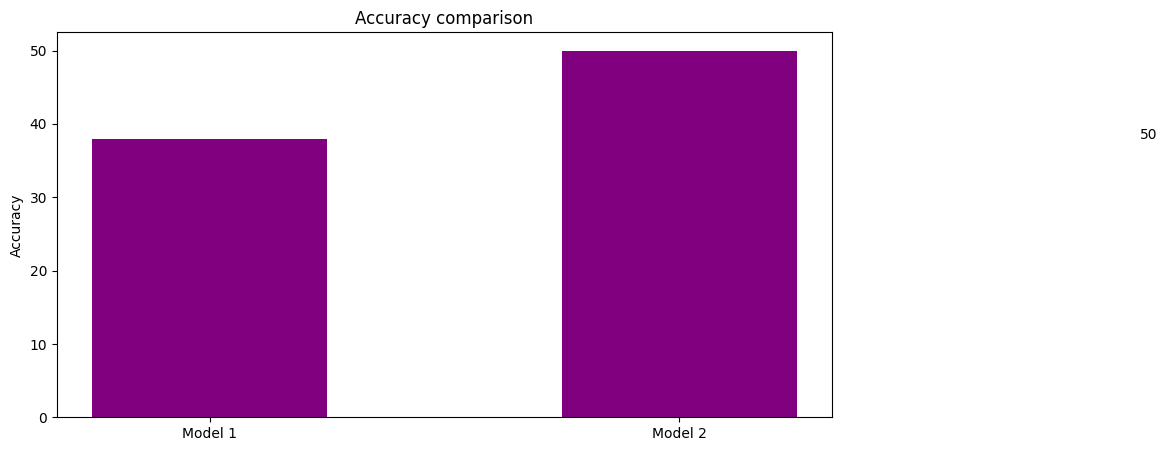

In [425]:
# creating the dataset
data = {'Model 1':acc_1, 'Model 2':acc_2}
models = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, values, color ='purple',
        width = 0.5)

plt.text("Text", acc_1, acc_2, ha = 'center')

plt.ylabel("Accuracy")

plt.savefig("model_acc.png")
plt.title("Accuracy comparison")
plt.show()

## Comparing accuracy

In [424]:
print(f'Accuracy of model 1: {acc_1}%, Accuracy of model 2: {acc_2}%')

Accuracy of model 1: 38%, Accuracy of model 2: 50%
